# 파이토치 MNIST 모델

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

- 현재 GPU 설정

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# 전처리 설정

In [3]:
transform = transforms.Compose([transforms.ToTensor(), # PIL 형식을 Tensor로 바꿔서 사용 
                                transforms.Normalize((0.5, ), (0.5))]) # mean과 std를 0.5씩 

# 데이터 로드 및 데이터 확인

In [4]:
# torchvision에서 제공하는 dataset에 MNIST가 있음. 우리는 그것을 사용할 예정
trainset = torchvision.datasets.MNIST(root='./data',
                                      train = True,
                                      download = True,
                                      transform=transform)

testset = torchvision.datasets.MNIST(root='./data',
                                      train = False,
                                      download = True,
                                      transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [32]:
# torch.uitls에서 제공하는 dataLoader를 사용하여 우리가 사용할 MNIST 데이터셋을 불러온다.
# 앞서 다운받은 trainset과 testset을 불러옴.
train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

# testset은 shuffle을 하지 않는다.
test_loader = DataLoader(testset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=2)

In [34]:
# train_loader를 image와 label로 분류
image, label = next(iter(train_loader)) 

In [9]:
# 나눈 image, label의 shape을 확인
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [10]:
# 불러온 이미지를 시각화하기위한 함수 작성
def imshow(img):
  img = img / 2 + 0.5 
  npimg = img.numpy() # 이미지를 넘파이로 변환
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # 넘파이 이미지를 (1, 2, 0)으로 tanspose
  plt.show()

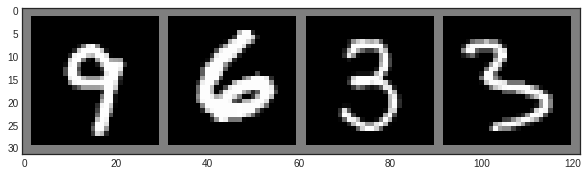

In [35]:
dataiter = iter(train_loader) # iter는 호출가능한 객체에서 반복을 끝낼 값주면 꺼내오며 반복종료 
images, labels = dataiter.next() # next는 값을 꺼내오는 파이썬 내장함수
imshow(torchvision.utils.make_grid(images[:4])) # make_grid를 통해 이미지를 여러개 가져올수 있음

# 신경망 구성

In [42]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3) # input 1, output 6
    self.conv2 = nn.Conv2d(6, 16, 3) # input 6, output 16
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5이미지를 120으로 펴줌
    self.fc2 = nn.Linear(120, 84) # input 120을 output 84로 변경 
    self.fc3 = nn.Linear(84, 10) # input 84를 output 10으로 변경

  # forward 함수를 통해 각 레이어를 연결 
  def forward(self, x): 
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # conv1을 relu를 거친후 2x2로 맥스풀링 
    x = F.max_pool2d(F.relu(self.conv2(x)), 2) # conv2을 relu를 거친후 2로 맥스풀링
    x = x.view(-1 ,self.num_flat_features(x)) # view를 통해 이미지를 flat하게 변경후 
    # fc1, 2, 3를 거치도록 해준다.
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) 
    return x

  # 입력이미지의 크기를 flat하게 구하는 함수 ex) 28x28(2차원)의 이미지를 784 (1차원)로 반환
  def num_flat_features(self, x): 
    size = x.size()[1:] # 입력이미지의 size를 가져온뒤
    num_features = 1
    for s in size: # size의 원소들을 곱하여 전체 feature의 개수를 구한다. 
      num_features *= s

    return num_features
  
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [43]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


## 임의의 값을 넣어 Forward값 확인

In [44]:
input=torch.randn(1, 1, 28, 28 )
out = net(input)
print(out)

tensor([[ 0.1469, -0.0149,  0.0505,  0.0079,  0.0640,  0.0271, -0.0843, -0.2203,
          0.0197,  0.0231]], grad_fn=<AddmmBackward0>)


# 손실함수와 옵티마이저

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9 )

# 모델 학습
- `optimizer.zero_grad` 가중치의 그레디언트 초기화
- loss 계산
- `loss.backward()`
- `optimizer.step()`: 업데이트 

In [46]:
total_batch = len(train_loader)
print(total_batch)

469


In [49]:
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels) # 예측값과 레이블값을 통해 오차를 구함 
    loss.backward() # 오차를 역전파 
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print(f"Epoch : {epoch+1}, Iter: {i+1}, Loss: {running_loss / 100}")
      running_loss =0.0

Epoch : 1, Iter: 100, Loss: 2.3074694204330446
Epoch : 1, Iter: 200, Loss: 2.287817988395691
Epoch : 1, Iter: 300, Loss: 2.270099046230316
Epoch : 1, Iter: 400, Loss: 2.2428951501846313
Epoch : 2, Iter: 100, Loss: 2.0925929844379425
Epoch : 2, Iter: 200, Loss: 1.761814172267914
Epoch : 2, Iter: 300, Loss: 1.1876262080669404
Epoch : 2, Iter: 400, Loss: 0.7499589025974274


# 모델의 저장 및 로드

In [50]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [51]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [52]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

# 모델 테스트

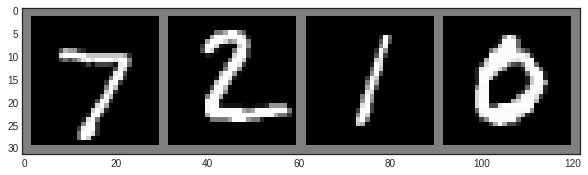

In [62]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

In [63]:
outputs = net(images)  # output을 하나 가져와서 

In [64]:
_, predicted = torch.max(outputs, 1) # 최대값들을 뽑아낸다.
print(predicted)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 0, 7, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 9, 2, 3, 5, 3, 2,
        4, 4, 6, 3, 5, 5, 2, 0, 4, 1, 9, 5, 7, 8, 4, 3, 7, 4, 2, 4, 3, 0, 7, 0,
        2, 8, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 9, 4, 7, 5, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 8, 6, 9, 6, 0, 5, 4, 4, 9, 2, 1, 9, 4, 8, 1, 3, 9, 7, 9, 9, 4, 4, 7,
        3, 4, 7, 6, 7, 9, 0, 5])


In [65]:
print(''.join('{}\t'.format(str(predicted[j].numpy())) for j in range(4)))

7	2	1	0	


In [67]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total+= labels.size(0)
    correct += (predicted == labels).sum().item()

  print(100 * correct / total)

84.34


# GPU 설정 후 학습
- 설정 후 

In [5]:
transform = transforms.Compose([transforms.ToTensor(), # PIL 형식을 Tensor로 바꿔서 사용 
                                transforms.Normalize((0.5, ), (0.5))]) # mean과 std를 0.5씩 

# torchvision에서 제공하는 dataset에 MNIST가 있음. 우리는 그것을 사용할 예정
trainset = torchvision.datasets.MNIST(root='./data',
                                      train = True,
                                      download = True,
                                      transform=transform)

testset = torchvision.datasets.MNIST(root='./data',
                                      train = False,
                                      download = True,
                                      transform=transform)

# torch.uitls에서 제공하는 dataLoader를 사용하여 우리가 사용할 MNIST 데이터셋을 불러온다.
# 앞서 다운받은 trainset과 testset을 불러옴.
train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

# testset은 shuffle을 하지 않는다.
test_loader = DataLoader(testset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [18]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3) # input 1, output 6
    self.conv2 = nn.Conv2d(6, 16, 3) # input 6, output 16
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5이미지를 120으로 펴줌
    self.fc2 = nn.Linear(120, 84) # input 120을 output 84로 변경 
    self.fc3 = nn.Linear(84, 10) # input 84를 output 10으로 변경

  # forward 함수를 통해 각 레이어를 연결 
  def forward(self, x): 
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # conv1을 relu를 거친후 2x2로 맥스풀링 
    x = F.max_pool2d(F.relu(self.conv2(x)), 2) # conv2을 relu를 거친후 2로 맥스풀링
    x = x.view(-1 ,self.num_flat_features(x)) # view를 통해 이미지를 flat하게 변경후 
    # fc1, 2, 3를 거치도록 해준다.
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) 
    return x

  # 입력이미지의 크기를 flat하게 구하는 함수 ex) 28x28(2차원)의 이미지를 784 (1차원)로 반환
  def num_flat_features(self, x): 
    size = x.size()[1:] # 입력이미지의 size를 가져온뒤
    num_features = 1
    for s in size: # size의 원소들을 곱하여 전체 feature의 개수를 구한다. 
      num_features *= s

    return num_features
  
net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [19]:
net = Net().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9 )

In [22]:
for epoch in range(20):

  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels) # 예측값과 레이블값을 통해 오차를 구함 
    loss.backward() # 오차를 역전파 
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print(f"Epoch : {epoch+1}, Iter: {i+1}, Loss: {running_loss / 100}")
      running_loss =0.0

Epoch : 1, Iter: 100, Loss: 0.862594867348671
Epoch : 1, Iter: 200, Loss: 0.6662433996796608
Epoch : 1, Iter: 300, Loss: 0.5491448137164116
Epoch : 1, Iter: 400, Loss: 0.5194235771894455
Epoch : 2, Iter: 100, Loss: 0.4343565836548805
Epoch : 2, Iter: 200, Loss: 0.3893258169293404
Epoch : 2, Iter: 300, Loss: 0.3610879926383495
Epoch : 2, Iter: 400, Loss: 0.3259082970023155
Epoch : 3, Iter: 100, Loss: 0.29339847892522813
Epoch : 3, Iter: 200, Loss: 0.2789557138085365
Epoch : 3, Iter: 300, Loss: 0.26688646964728835
Epoch : 3, Iter: 400, Loss: 0.24908121526241303
Epoch : 4, Iter: 100, Loss: 0.22566454946994782
Epoch : 4, Iter: 200, Loss: 0.2167759197205305
Epoch : 4, Iter: 300, Loss: 0.20734639301896096
Epoch : 4, Iter: 400, Loss: 0.18594766192138196
Epoch : 5, Iter: 100, Loss: 0.17621649272739887
Epoch : 5, Iter: 200, Loss: 0.17601138286292553
Epoch : 5, Iter: 300, Loss: 0.16302704751491548
Epoch : 5, Iter: 400, Loss: 0.15906946249306203
Epoch : 6, Iter: 100, Loss: 0.14981670558452606
Epo

In [23]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total+= labels.size(0)
    correct += (predicted == labels).sum().item()

  print(100 * correct / total)

98.34
